In [4]:
#!pip install tensorflow 
#!pip install yahoo_fin 
#!pip install plot_keras_history

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt


import os
import numpy as np
import pandas as pd
import random

import detrendPrice 
import WhiteRealityCheckFor1 

SEED=1052
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [8]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [9]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [10]:
# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 3
# Amazon stock market
ticker = "AMZN"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [11]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [12]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)


In [37]:
df=data["df"]
df['Datetime']=pd.to_datetime(df.index)
df.set_index('Datetime')

#save the close and open for white reality check
open_price=df['open'].copy()
close_price=df['close'].copy()

#build the best window features after the exploratory data analysis:
for n in list(range(1,21)):
    name = 'ret' + str(n)
    df[name] = df['open'].pct_change(periods=n)
    #df[name] = df['close'].pct_change(periods=n)

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
df['retFut1'] = df['open'].pct_change(1).shift(-1).fillna(0)

#transform the target
df['retFut1_categ'] = np.where((df['retFut1'] > 0), 1, 0)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['high'] = df['high'].shift(1)
df['low'] = df['low'].shift(1)
df['close'] = df['close'].shift(1)
df['volume'] = df['volume'].shift(1)

#select the features (by dropping)
cols_to_drop=['open','close','low','high','adjclose','volume','ticker']
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ'], axis=1) 
y = df_filtered[['retFut1_categ']]

df_train=df_filtered.iloc[0:5028]
df_test=df_filtered.iloc[5029:6287]

In [16]:
# construct model 1

model1 = create_model(N_STEPS, len(FEATURE_COLUMNS), loss='mae', units=300, cell=CELL, n_layers=3,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=True)
# some tensorflow callbacks
checkpointer1 = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard1 = TensorBoard(log_dir=os.path.join("logs", model_name))

# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history1 = model1.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer1, tensorboard1],
                    verbose=1)

Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 0.0284 - mean_absolute_error: 0.0284
Epoch 1: val_loss improved from inf to 0.01496, saving model to results/2022-08-08_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
79/79 [==============================] - 330s 4s/step - loss: 0.0284 - mean_absolute_error: 0.0284 - val_loss: 0.0150 - val_mean_absolute_error: 0.0150
Epoch 2/10
79/79 [==============================] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.0190
Epoch 2: val_loss improved from 0.01496 to 0.01139, saving model to results/2022-08-08_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
79/79 [==============================] - 256s 3s/step - loss: 0.0190 - mean_absolute_error: 0.0190 - val_loss: 0.0114 - val_mean_absolute_error: 0.0114
Epoch 3/10
79/79 [==============================] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.0193
Epoch 3: val_loss did not improve from 0.01139
79/79 

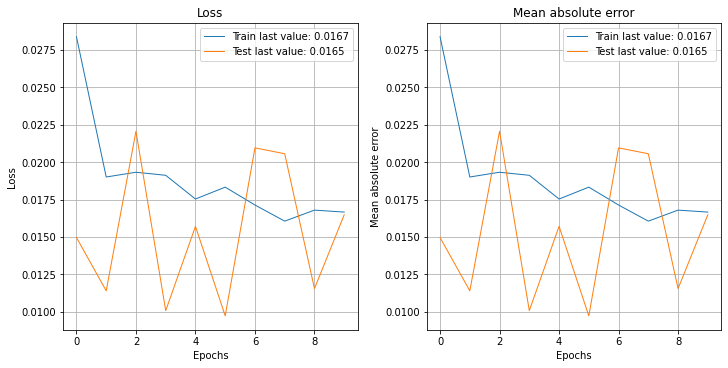

In [17]:
show_history(history1)

In [21]:
# construct model 2

model2 = create_model(N_STEPS, len(FEATURE_COLUMNS), loss="huber_loss", units=300, cell=CELL, n_layers=3,
                    dropout=DROPOUT, optimizer='SGD', bidirectional=False)
# some tensorflow callbacks
checkpointer2 = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard2 = TensorBoard(log_dir=os.path.join("logs", model_name))

# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history2 = model2.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=5,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer2, tensorboard2],
                    verbose=1)

Epoch 1/5
79/79 [==============================] - ETA: 0s - loss: 0.0182 - mean_absolute_error: 0.1250
Epoch 1: val_loss improved from inf to 0.00924, saving model to results/2022-08-08_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
79/79 [==============================] - 106s 1s/step - loss: 0.0182 - mean_absolute_error: 0.1250 - val_loss: 0.0092 - val_mean_absolute_error: 0.1055
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0765
Epoch 2: val_loss improved from 0.00924 to 0.00235, saving model to results/2022-08-08_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
79/79 [==============================] - 99s 1s/step - loss: 0.0053 - mean_absolute_error: 0.0765 - val_loss: 0.0024 - val_mean_absolute_error: 0.0501
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0374
Epoch 3: val_loss improved from 0.00235 to 0.00060, savin

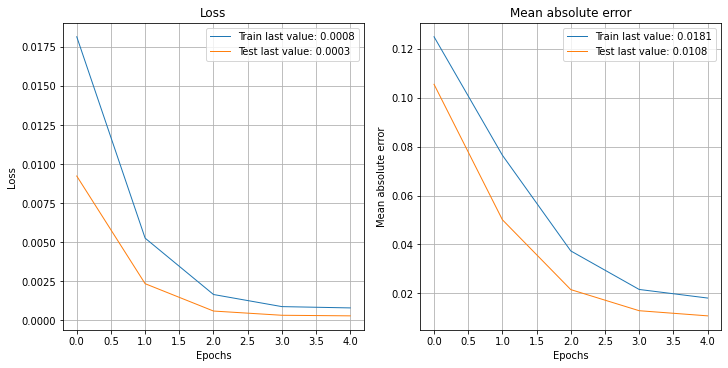

In [27]:
show_history(history2)

In [22]:
# construct model 3
model3 = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer3 = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard3 = TensorBoard(log_dir=os.path.join("logs", model_name))

# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history3 = model3.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer3, tensorboard3],
                    verbose=1)

Epoch 1/3
79/79 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0308
Epoch 1: val_loss improved from inf to 0.00025, saving model to results/2022-08-08_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
79/79 [==============================] - 55s 637ms/step - loss: 0.0024 - mean_absolute_error: 0.0308 - val_loss: 2.4630e-04 - val_mean_absolute_error: 0.0106
Epoch 2/3
79/79 [==============================] - ETA: 0s - loss: 6.1161e-04 - mean_absolute_error: 0.0165
Epoch 2: val_loss did not improve from 0.00025
79/79 [==============================] - 49s 615ms/step - loss: 6.1161e-04 - mean_absolute_error: 0.0165 - val_loss: 2.6715e-04 - val_mean_absolute_error: 0.0105
Epoch 3/3
79/79 [==============================] - ETA: 0s - loss: 6.6651e-04 - mean_absolute_error: 0.0169
Epoch 3: val_loss did not improve from 0.00025
79/79 [==============================] - 49s 620ms/step - loss: 6.6651e-04 - mean_absolute_error: 0.0169

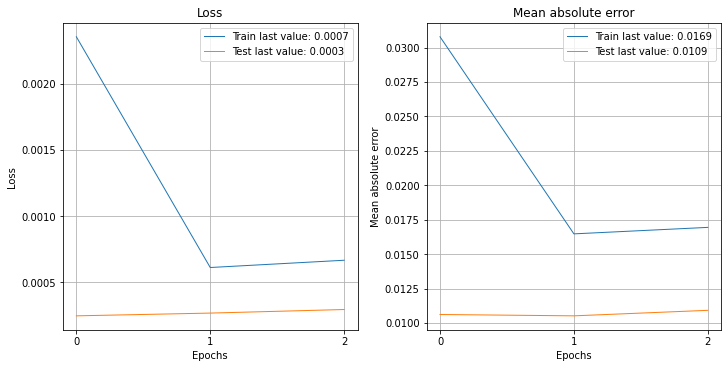

In [28]:
show_history(history3)

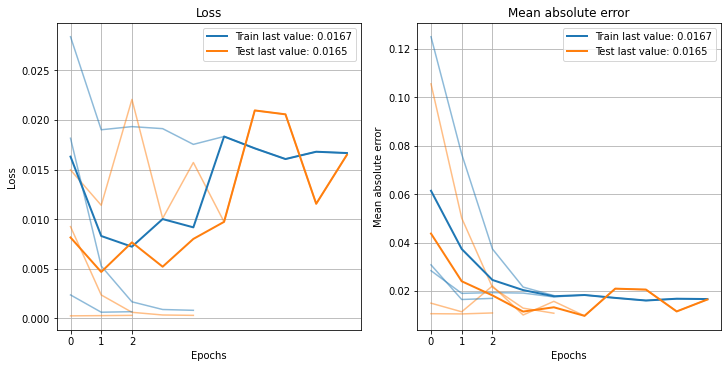

In [26]:
histories=[history1,history2,history3]
plot_history(
    histories,
    show_standard_deviation=False,
    show_average=True
)
plt.show()
plt.close()

Model 3 performed the best with loss=0.000582 and MAE=0.016. There model 3 is the best model that we will use for predicting stock prices on our data.

In [30]:
best_model=model3

In [34]:
#Making "predictions" on training set (in-sample)
positions_train = np.where(best_model.predict(data['X_train'])> 0,1,-1 ).flatten()
dailyRet_train = pd.Series(positions_train).fillna(0).values * df_train.retFut1 #for trading right after the open
dailyRet_train = dailyRet_train.fillna(0)
cumret_train = np.cumprod(dailyRet_train + 1) - 1



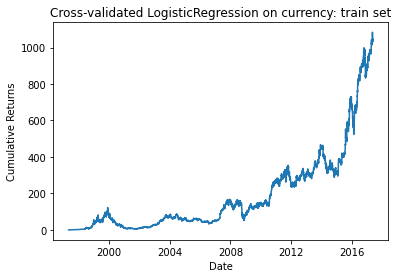


In-sample: CAGR=0.416898 Sparpe ratio=0.858962


In [35]:
plt.figure(1)
plt.plot(cumret_train.index, cumret_train)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()

cagr_train = (1 + cumret_train[-1]) ** (252 / len(cumret_train)) - 1
ratio_train = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_train) / np.std(dailyRet_train)

print(('\nIn-sample: CAGR={:0.6} Sparpe ratio={:0.6}').format(cagr_train,ratio_train))

In [38]:
#Making "predictions" on test set (out-of-sample)
positions_test = np.where(best_model.predict(data['X_test'])> 0,1,-1 ).flatten()
dailyRet_test = pd.Series(positions_test).fillna(0).values * df_test.retFut1 #for trading right after the open
dailyRet_test = dailyRet_test.fillna(0)
cumret_test = np.cumprod(dailyRet_test + 1) - 1

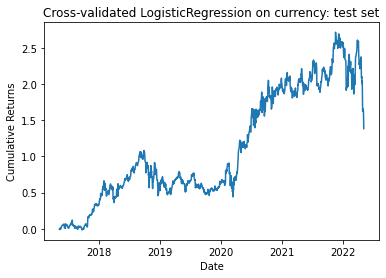


Out-of-sample: CAGR=0.18994 Sparpe ratio=0.683054 


In [39]:
plt.figure(2)
plt.plot(cumret_test.index, cumret_test)
plt.title('Cross-validated LogisticRegression on currency: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()

cagr_test = (1 + cumret_test[-1]) ** (252 / len(cumret_test)) - 1
ratio_test = (252.0 ** (1.0/2.0)) * np.mean(dailyRet_test) / np.std(dailyRet_test)


print(('\nOut-of-sample: CAGR={:0.6} Sparpe ratio={:0.6} ').format(cagr_test,ratio_test))

average return 0.000934
[-0.00349948  0.00349491]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.2992


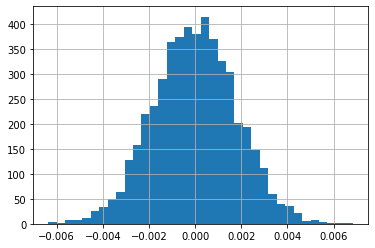

In [40]:
#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice.detrendPrice(open_price[5025:6282])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions_test).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()

In [41]:
def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [42]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [43]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [44]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
best_model.load_weights(model_path)

In [45]:
# evaluate the model
loss, mae = best_model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [46]:
# get the final dataframe for the testing set
final_df = get_final_df(best_model, data)

In [47]:
# predict the future price
future_price = predict(best_model, data)

In [48]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [49]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 137.71$
huber_loss loss: 0.00024629771360196173
Mean Absolute Error: 2.049548998676125
Accuracy score: 0.5771065182829889
Total buy profit: 761.969560354948
Total sell profit: 174.89358113706112
Total profit: 936.8631414920092
Profit per trade: 0.7447242778155876


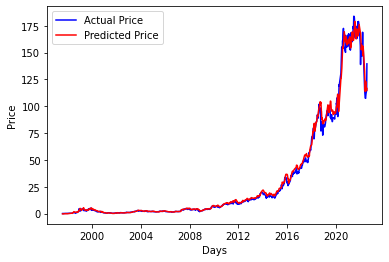

In [50]:
# plot true/pred prices graph
plot_graph(final_df)

In [51]:
print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

                  open        high         low       close    adjclose  \
2022-03-23  163.705002  166.369995  162.686996  163.408005  163.408005   
2022-05-06  114.849998  119.050499  113.081497  114.772499  114.772499   
2022-05-24  104.025002  105.400002  101.260002  104.099998  104.099998   
2022-06-06  125.250000  128.990005  123.809998  124.790001  124.790001   
2022-06-07  122.010002  124.099998  120.629997  123.000000  123.000000   
2022-06-16  104.470001  104.580002  102.010002  103.660004  103.660004   
2022-07-05  107.599998  114.080002  106.320000  113.500000  113.500000   
2022-07-07  113.849998  116.989998  113.489998  116.330002  116.330002   
2022-07-11  114.080002  114.300003  110.870003  111.750000  111.750000   
2022-07-13  107.029999  111.779999  106.010002  110.400002  110.400002   

               volume ticker  adjclose_15  true_adjclose_15  buy_profit  \
2022-03-23   55812000   AMZN   155.769485        155.541000    0.000000   
2022-05-06  124260000   AMZN   132.